In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.backend import tf as ktf
from  skimage import transform
import numpy as np
from keras.callbacks import *

In [3]:
from numpy.random import seed
seed(112)
from tensorflow import set_random_seed
set_random_seed(221)


In [4]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [5]:
TF_ENABLE_WINOGRAD_NONFUSED=1
!export TF_ENABLE_WINOGRAD_NONFUSED=1;

In [6]:
# Hyperparameters
#batch_size = 128
batch_size = 512  # --- Since image size is 16x16, and applicable on V100
num_classes = 10
#epochs = 20
epochs = 75
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [7]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [8]:
import numpy as np


class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [9]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

mean_cifar10 = [125.3, 123.0, 113.9]
std_cifar10  = [63.0,  62.1,  66.7]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Perchannel normalization
def defnormalize_image_by_chanel(img):
    new_img = np.zeros(img.shape)
    mean_cifar10 = [125.3, 123.0, 113.9]
    std_cifar10  = [63.0,  62.1,  66.7]
    for i in range(3):
        new_img[:, :, i] = (img[:, :, i] - mean_cifar10[i]) / std_cifar10[i]
    return new_img

x_train = np.asarray([defnormalize_image_by_chanel(image) for image in x_train])
x_test = np.asarray([defnormalize_image_by_chanel(image) for image in x_test])


#Reducing the size of the images to 16x16 initially
new_shape = (16,16,3)
x_train = np.asarray([transform.resize(image, new_shape) for image in x_train])
x_test = np.asarray([transform.resize(image, new_shape) for image in x_test])
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

170500096/170498071 [==============================] - 18s 0us/step


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [10]:
print(x_train.shape)
print(type(x_train))

(50000, 16, 16, 3)
<class 'numpy.ndarray'>


In [11]:

datagen_bm = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=15,
    width_shift_range=5./32,
    height_shift_range=5./32,
    horizontal_flip=True)
                    
datagen_k = MixupGenerator(x_train, y_train,  batch_size=batch_size, alpha=0.3, datagen=datagen_bm)()




In [12]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [13]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [14]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    #flat = Flatten()(AvgPooling)
    flat = GlobalAveragePooling2D()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [15]:
num_filter = 22
dropout_rate = 0.2
l = 20
##l = 44
##num_filter = 11
##input = Input(shape=(img_height, img_width, channel,))
input = Input(shape=(None, None, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [16]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 2 594         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 2 88          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 2 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [17]:
# determine Loss function and Optimizer

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])


In [18]:
clr_triangular = CyclicLR(base_lr=0.1, max_lr=4.0,step_size=3662, mode='triangular')


#May be near to https://arxiv.org/abs/1506.01186 (with a single cycle (a.k.a 1-Cycle policy)) using call backs. Need to try and then verify.
#model.fit_generator(datagen_k.flow(x_train, y_train,  batch_size=batch_size), steps_per_epoch = np.ceil(len(x_train)//batch_size), verbose=1, epochs=epochs, validation_data=(x_test, y_test), callbacks=[clr_triangular])

#Using both mix up and single cycle (a.k.a 1-Cycle policy)
model.fit_generator(generator = datagen_k, steps_per_epoch = np.ceil(len(x_train)//batch_size), verbose=1, epochs=epochs, validation_data=(x_test, y_test), callbacks=[clr_triangular])


Epoch 1/75
97/97 [==============================] - 86s 885ms/step - loss: 2.0327 - acc: 0.2550 - val_loss: 2.0984 - val_acc: 0.3350
Epoch 2/75
97/97 [==============================] - 60s 620ms/step - loss: 1.8337 - acc: 0.3617 - val_loss: 3.8584 - val_acc: 0.2277
Epoch 3/75
97/97 [==============================] - 60s 619ms/step - loss: 1.7270 - acc: 0.4143 - val_loss: 2.7394 - val_acc: 0.3441
Epoch 4/75
97/97 [==============================] - 60s 618ms/step - loss: 1.6380 - acc: 0.4606 - val_loss: 3.1778 - val_acc: 0.3622
Epoch 5/75
97/97 [==============================] - 60s 619ms/step - loss: 1.5763 - acc: 0.4934 - val_loss: 1.8862 - val_acc: 0.4646
Epoch 6/75
97/97 [==============================] - 60s 619ms/step - loss: 1.5175 - acc: 0.5229 - val_loss: 1.5620 - val_acc: 0.5356
Epoch 7/75
97/97 [==============================] - 60s 619ms/step - loss: 1.4698 - acc: 0.5445 - val_loss: 1.5679 - val_acc: 0.5408
Epoch 8/75
97/97 [==============================] - 60s 620ms/step - 

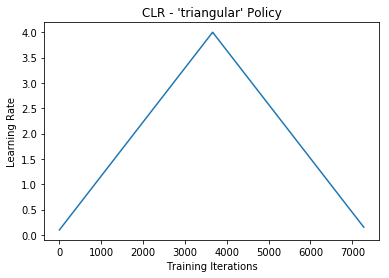

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [20]:
# Test the model - 1st time with reduced image size
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 6s 590us/step
Test loss: 0.5257053505420685
Test accuracy: 0.8277


In [21]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_75_epochs_size_16_channel_preprocess_sc_mixup.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
model.load_weights("DNST_model_75_epochs_size_16_channel_preprocess_sc_mixup.h5")
print("load model from disk")

load model from disk


In [18]:
# Load CIFAR10 Data - Original Size
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

mean_cifar10 = [125.3, 123.0, 113.9]
std_cifar10  = [63.0,  62.1,  66.7]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Perchannel normalization
def defnormalize_image_by_chanel(img):
    new_img = np.zeros(img.shape)
    mean_cifar10 = [125.3, 123.0, 113.9]
    std_cifar10  = [63.0,  62.1,  66.7]
    for i in range(3):
        new_img[:, :, i] = (img[:, :, i] - mean_cifar10[i]) / std_cifar10[i]
    return new_img

x_train = np.asarray([defnormalize_image_by_chanel(image) for image in x_train])
x_test = np.asarray([defnormalize_image_by_chanel(image) for image in x_test])




In [24]:
batch_size = 256
datagen_k = MixupGenerator(x_train, y_train,  batch_size=batch_size, alpha=0.4, datagen=datagen_bm)()

In [25]:
# determine Loss function and Optimizer
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])


In [26]:
batch_size = 256
epochs = 150

s_size = np.ceil((((len(x_train)/batch_size)) * epochs)/2)

clr_triangular = CyclicLR(base_lr=0.1, max_lr=4.0,step_size=s_size, mode='triangular')


#May be near to https://arxiv.org/abs/1506.01186 (with a single cycle (a.k.a 1-Cycle policy)) using call backs. Need to try and then verify.
#model.fit_generator(datagen_k.flow(x_train, y_train,  batch_size=batch_size), steps_per_epoch = np.ceil(len(x_train)//batch_size), verbose=1, epochs=epochs, validation_data=(x_test, y_test), callbacks=[clr_triangular])

#Using both mix up and single cycle (a.k.a 1-Cycle policy)
model.fit_generator(generator = datagen_k, steps_per_epoch = np.ceil(len(x_train)//batch_size), verbose=1, epochs=epochs, validation_data=(x_test, y_test), callbacks=[clr_triangular])



Epoch 1/150
195/195 [==============================] - 79s 406ms/step - loss: 1.1131 - acc: 0.7313 - val_loss: 0.6798 - val_acc: 0.7855
Epoch 2/150
195/195 [==============================] - 61s 310ms/step - loss: 1.0509 - acc: 0.7566 - val_loss: 0.5814 - val_acc: 0.8171
Epoch 3/150
195/195 [==============================] - 60s 310ms/step - loss: 1.0293 - acc: 0.7696 - val_loss: 0.5640 - val_acc: 0.8197
Epoch 4/150
195/195 [==============================] - 61s 310ms/step - loss: 1.0074 - acc: 0.7781 - val_loss: 0.5227 - val_acc: 0.8323
Epoch 5/150
195/195 [==============================] - 61s 312ms/step - loss: 0.9950 - acc: 0.7826 - val_loss: 0.4550 - val_acc: 0.8545
Epoch 6/150
195/195 [==============================] - 60s 310ms/step - loss: 0.9880 - acc: 0.7864 - val_loss: 0.5012 - val_acc: 0.8394
Epoch 7/150
195/195 [==============================] - 61s 311ms/step - loss: 0.9802 - acc: 0.7923 - val_loss: 0.5411 - val_acc: 0.8290
Epoch 8/150
195/195 [===========================

Epoch 61/150
195/195 [==============================] - 61s 312ms/step - loss: 0.9296 - acc: 0.8175 - val_loss: 0.8028 - val_acc: 0.7792
Epoch 62/150
195/195 [==============================] - 61s 311ms/step - loss: 0.9358 - acc: 0.8135 - val_loss: 0.5357 - val_acc: 0.8472
Epoch 63/150
195/195 [==============================] - 61s 312ms/step - loss: 0.9316 - acc: 0.8178 - val_loss: 0.5811 - val_acc: 0.8246
Epoch 64/150
195/195 [==============================] - 61s 311ms/step - loss: 0.9289 - acc: 0.8174 - val_loss: 0.4938 - val_acc: 0.8566
Epoch 65/150
195/195 [==============================] - 61s 310ms/step - loss: 0.9340 - acc: 0.8148 - val_loss: 0.4604 - val_acc: 0.8596
Epoch 66/150
195/195 [==============================] - 61s 312ms/step - loss: 0.9234 - acc: 0.8204 - val_loss: 0.5532 - val_acc: 0.8343
Epoch 67/150
195/195 [==============================] - 60s 310ms/step - loss: 0.9309 - acc: 0.8195 - val_loss: 0.6078 - val_acc: 0.8218
Epoch 68/150
195/195 [===================

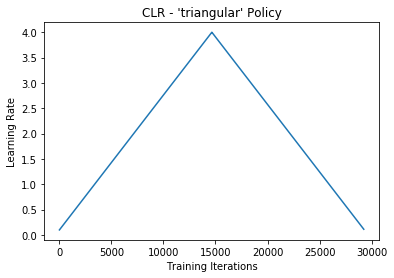

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [28]:
# Test the model - 32x32 Image Size
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 5s 532us/step
Test loss: 0.2640875468611717
Test accuracy: 0.9238


In [29]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_150_epochs_size_32_channel_preprocess_sc_mixup.h5")
print("Saved model to disk")

Saved model to disk


In [30]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import files

files.download('DNST_model.h5')